## **Environmental Sound Classification using Spectograms with CNN Model**

# ***1)Importing necessary libraries***

In [ ]:
 !pip3 install pydub

In [ ]:
import os
import shutil
import urllib
import zipfile
import glob
import urllib.request
import pandas as pd
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D,MaxPooling2D ,Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib.backends.backend_agg import FigureCanvasAgg
from pydub import AudioSegment
import torch
import tensorflow as tf
import torch.nn as nn

# **2) Connecting Google Drive to Access Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
esc_50 = pd.read_csv('/content/drive/MyDrive/ESC-50-master/meta/esc50.csv')

In [ ]:
esc_50.head(40)

# **3) Creating Spectograms**

*Loading the csv file and filtering the classes in order to obtain spectograms for sound files for each classes. By changing the target number interval each classes were obtained*

In [ ]:
COLAB = True

Processing helicopter genre...
Processing chainsaw genre...
Processing siren genre...
Processing car_horn genre...
Processing engine genre...
Processing train genre...
Processing church_bells genre...
Processing airplane genre...
Processing fireworks genre...
Processing hand_saw genre...


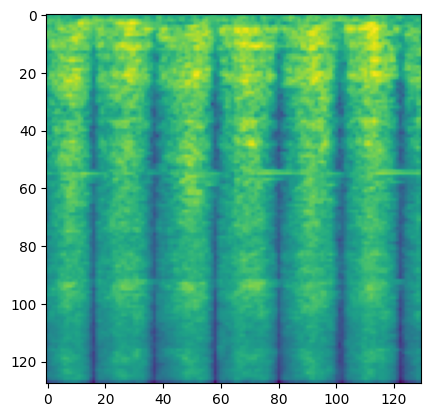

In [ ]:
if COLAB:
    dataset_dir = '/content/drive/MyDrive/ESC-50-master'
    audio_dir = '/content/drive/MyDrive/ESC-50-master/audio'
    specs_dir = '/content/drive/MyDrive/esc_specs'
else:
    dataset_dir = './ESC-50-master'
    audio_dir = './ESC-50-master/audio'
    specs_dir = './esc_specs'

# Load ESC-50 dataset
metadata_path = os.path.join(dataset_dir, 'meta/esc50.csv')
metadata = pd.read_csv(metadata_path)

#filtering for specific groups
metadata = metadata[(metadata['target'] >= 40) & (metadata['target'] <= 49)]

# Group metadata by target (genre) column
metadata_groups = metadata.groupby('target')

# Loop over each genre and extract filenames
for target, group in metadata_groups:
    genre_name = group.iloc[0]['category']
    print(f"Processing {genre_name} genre...")

    # Create genre directory in specs_dir
    genre_dir = os.path.join(specs_dir, 'Train', genre_name)
    os.makedirs(genre_dir, exist_ok=True)

    # Extract filenames for the current genre
    filenames = group['filename'].tolist()

    # Loop over each filename in the current genre and create spectrogram
    for i, filename in enumerate(filenames):
        audio_path = os.path.join(audio_dir, filename)
        y, sr = librosa.load(audio_path, duration=3)
        mels = librosa.feature.melspectrogram(y=y, sr=sr)
        fig = plt.Figure()
        canvas = FigureCanvasAgg(fig)
        p = plt.imshow(librosa.power_to_db(mels, ref=np.max))
        spec_path = os.path.join(genre_dir, f"{genre_name}{i}.png")
        plt.savefig(spec_path)

# **4) Loading the data to the torch sensors**
By changing the directory , different datasets for the classification tasks were considered. Human, Animals,...ESC-10,ESC-50.

In [ ]:
directory = "/content/drive/MyDrive/esc_specs/Train/Animals"
import torchvision.transforms as T
import torchvision.datasets as datasets
import torchvision.transforms as transforms

batch_size = 25
image_size = 288
train_trms = T.Compose([
T.Resize(image_size),
T.RandomRotation(20),
T.RandomHorizontalFlip(),
T.ToTensor()])
val_trms = T.Compose([
T.Resize(image_size),
T.ToTensor()])
train_data = datasets.ImageFolder(root = directory, transform = train_trms)
val_data = datasets.ImageFolder(root = directory, transform = val_trms)

torch.manual_seed(43)
train_size = int(0.70 * len(train_data))
val_size = len(train_data) - train_size

from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)


(280, 120)

In [ ]:
batch_size = 25

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)

In [ ]:
# Assuming you have already loaded the dataset as train_data
sample_image, _ = train_data[0]  # Retrieve a sample image from the dataset
image_size = sample_image.size()  # Get the size of the image tensor
image_height, image_width = image_size[1], image_size[2]  # Extract height and width
print("Size of the resized images:", image_height, "x", image_width)


Size of the resized images: 288 x 384


# **5)** **Checking the devive type (CPU or GPU)**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

# **6) The CNN Model and Training**

In [ ]:
import torch.nn as nn
class env_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(env_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=8960 ,out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

    self.dropout = nn.Dropout(p=0.2, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = F.softmax(x)

    return x


def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.002)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []


  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss.detach().cpu().item()/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc

# **The train_dl (train data set) changes while the directory is changed in section 4 for the different classification**




In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model_human = to_device(env_net_human(), device)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model_animal = to_device(env_net_animal(), device)

In [ ]:

train_loss, train_acc, validation_loss, validation_acc = train(model_human, device, train_dl, val_dl, 50)


  0%|          | 0/50 [00:00<?, ?epoch/s]

<ipython-input-51-bb0ef35e2611>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [ ]:
train_loss, train_acc, validation_loss, validation_acc = train(model_animal, device, train_dl, val_dl, 50)


  0%|          | 0/50 [00:00<?, ?epoch/s]

<ipython-input-63-a1027d9066cb>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


# **7) Results**

<function matplotlib.pyplot.show(close=None, block=None)>

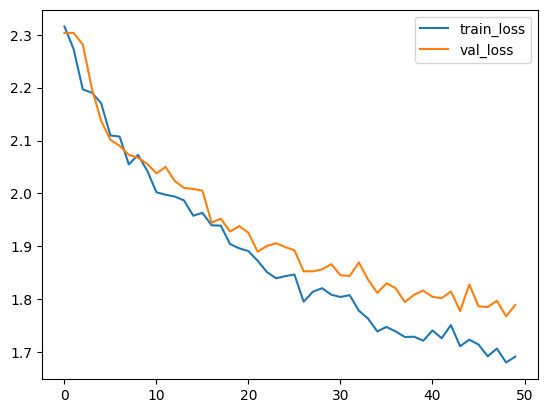

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

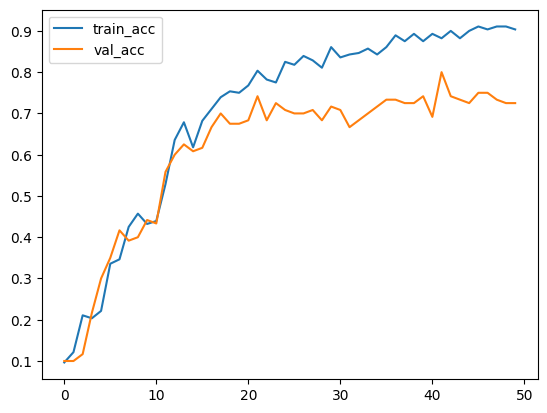

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_acc, label='train_acc')
plt.plot(validation_acc,label='val_acc')
plt.legend()
plt.show

Confusion matrix 1 (for thematic groups and esc-10)

<ipython-input-51-bb0ef35e2611>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


<Axes: >

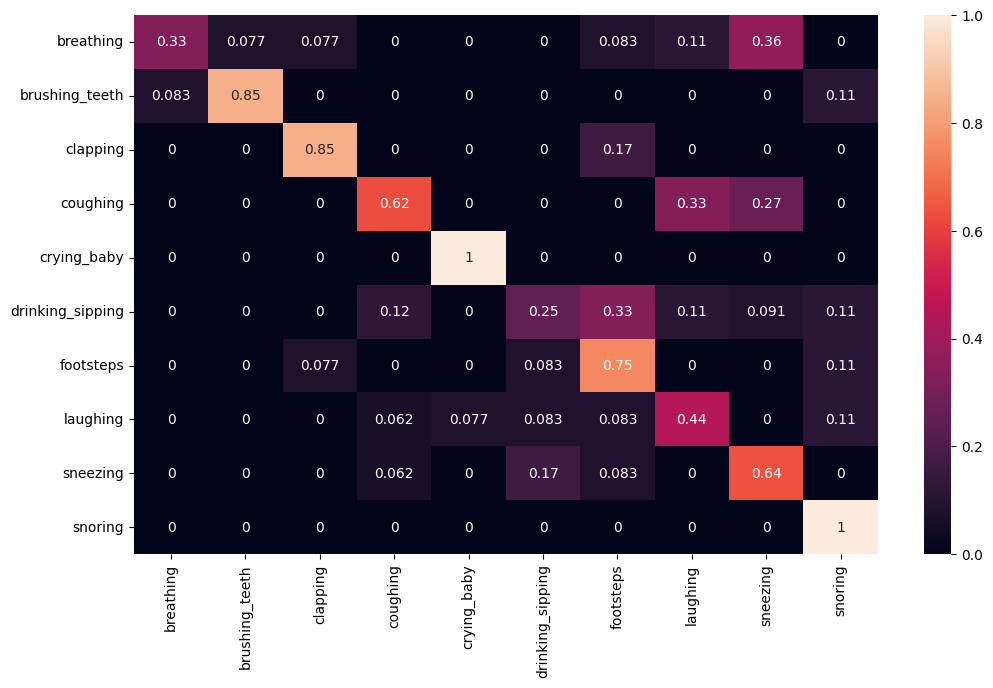

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_dl:
        output = model_human(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = train_data.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

Confusion matrix for esc-50

In [ ]:
import seaborn as sb
sb.set(style="white", palette="muted")
f = plt.figure(figsize=(20, 20))
conf = cf_matrix * 1000 / 10.0 / cf_matrix.sum(axis=1)[:, np.newaxis]
plt.imshow(conf, interpolation='nearest', cmap=sb.light_palette((53./255., 189./255., 228/255.), input="rgb", as_cmap=True))
#plt.imshow(conf, interpolation='nearest', cmap=sb.light_palette((226./255., 56./255., 108/255.), input="rgb", as_cmap=True))

ticks = ['Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat', 'Hen', 'Insects', 'Sheep', 'Crow', 'Rain', 'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops', 'Wind', 'Pouring water', 'Toilet flush', 'Thunderstorm', 'Crying baby', 'Sneezing', 'Clapping', 'Breathing', 'Coughing', 'Footsteps', 'Laughing', 'Brushing teeth', 'Snoring', 'Drinking - sipping', 'Door knock', 'Mouse click', 'Keyboard typing', 'Door/wood creaks', 'Can opening', 'Washing machine', 'Vacuum cleaner', ' Clock alarm', 'Clock tick', 'Glass breaking', 'Helicopter', 'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train', 'Church bells', 'Airplane', 'Fireworks', 'Hand saw']
short_ticks = ['DO', 'RO', 'PI', 'CO', 'FR', 'CA', 'HE', 'IN', 'SH', 'CR', 'RA', 'SW', 'FI', ' CR', 'CB', 'WD', 'WI', 'PW', 'TF', 'TH', 'CB', 'PS', 'CL', 'BR', 'CO', 'FO', 'LA', 'BT', 'SN', 'DS', 'DK', 'MC', 'KT', 'DW', 'CO', 'WM', 'VC', 'CA', 'CT', 'GB', 'HE', 'CH', 'SI', 'CH', 'EN', 'TR', 'CB', 'AI', 'FI', 'HS']
plt.xticks(range(0, 50), short_ticks)
plt.yticks(range(0, 50), ticks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

for x in range(50):
    for y in range(50):
        if x == y:
            if int(conf[y, x]) > 25:
                plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center', color='white')
            else:
                plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center', color='gray')
            pass

plt.savefig('figure_conf_50_light_poster.pdf', bbox_inches='tight')

for x in range(50):
    for y in range(50):
        if x != y:
            if int(conf[y, x]) != 0:
                plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center', color='gray')

plt.savefig('figure_conf_50_dense_poster.pdf', bbox_inches='tight')

In [ ]:
from torchvision.transforms import ToTensor
from PIL import Image
def predict(image_data, model):
    img = Image.open(image_data)
    img = img.convert('RGB')
    transform_norm = transforms.Compose([transforms.ToTensor(), transforms.Resize((288))])
    img_normalized = transform_norm(img).float()
    img_normalized=img_normalized.to('cuda') # changes when the device type is changed
    img_normalized = img_normalized.unsqueeze_(0)
    # input = Variable(image_tensor)
    # print(img_normalized.shape)
    with torch.no_grad():
      model.eval()
      output =model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      classes = train_data_human.classes
      class_name = classes[index]
      return class_name

In [ ]:
model_animal = env_net_animal()
model_animal.load_state_dict(torch.load('/content/drive/MyDrive/esc_specs/Train/Interior_Model.pt'))
model_animal = model_animal.to(device)
model_animal.eval()

predict_class = predict('/content/drive/MyDrive/esc_specs/Train/Interior/washing_machine/washing_machine11.png',model_animal, "interior")
print(predict_class)

washing_machine


<ipython-input-10-a1027d9066cb>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)



**<font color='yellow'><h1><center>   DEMO</center></h1>**</font>


# **8) Prediction of the Sound taken from Internet(Youtube, etc.)**

* Saving spectogram of that sound



Saving spectrogram: /content/drive/MyDrive/esc_specs/YOUTUBE-SPECS/test_dog.png


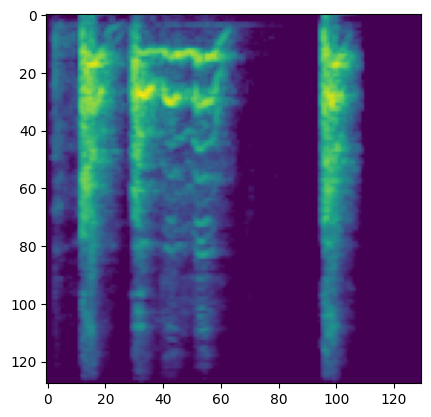

In [ ]:
#Taking a song that is not in the training file

song ='/content/drive/MyDrive/esc_specs/YOUTUBE-AUD/onlymp3.to - Labrador Dog Barking Sound - The SOund ButtOn-c13MliefckM-192k-1688564038.mp3'
y, sr = librosa.load(song, duration=3)
mels = librosa.feature.melspectrogram(y=y, sr=sr)
fig = plt.Figure()
canvas = FigureCanvasAgg(fig)
p = plt.imshow(librosa.power_to_db(mels, ref=np.max))
print(f'Saving spectrogram: /content/drive/MyDrive/esc_specs/YOUTUBE-SPECS/test_dog.png')

if COLAB:
    plt.savefig(
        f'/content/drive/MyDrive/esc_specs/YOUTUBE-SPECS/test_dog.png')
else:
    plt.savefig(f'./content/drive/MyDrive/esc_specs/YOUTUBE-SPECS/test_dog.png')

* Prediction function

In [ ]:
from torchvision import datasets, transforms
from PIL import Image
import torch
from torchvision.transforms import ToTensor
from PIL import Image

def predict(image_data, model, train_data):
    img = Image.open(image_data)
    img = img.convert('RGB')
    transform_norm = transforms.Compose([transforms.ToTensor(), transforms.Resize((288))])
    img_normalized = transform_norm(img).float()
    img_normalized = img_normalized.to('cpu') # changes when the device type is changed
    img_normalized = img_normalized.unsqueeze_(0)
    with torch.no_grad():
        model = model.to('cpu')  # Ensure model is on CPU
        model.eval()
        output = model(img_normalized)
        index = output.data.cpu().numpy().argmax()

        # Select train_data based on condition
        if train_data == "human":
            directory_human = "/content/drive/MyDrive/esc_specs/Train/Human"
            train_data_human = datasets.ImageFolder(root = directory_human, transform = train_trms)
            classes = train_data_human.classes
        elif train_data == "animal":
            directory_animal = "/content/drive/MyDrive/esc_specs/Train/Animals"
            train_data_animal = datasets.ImageFolder(root = directory_animal, transform = train_trms)
            classes = train_data_animal.classes
        elif train_data == "interior":
            directory_interior = "/content/drive/MyDrive/esc_specs/Train/Interior"
            train_data_interior = datasets.ImageFolder(root = directory_interior, transform = train_trms)
            classes = train_data_interior.classes
        elif train_data == "natural":
            directory_natural = "/content/drive/MyDrive/esc_specs/Train/Natural"
            train_data_natural = datasets.ImageFolder(root = directory_natural, transform = train_trms)
            classes = train_data_natural.classes
        elif train_data == "exterior":
            directory_exterior = "/content/drive/MyDrive/esc_specs/Train/Exterior"
            train_data_ext = datasets.ImageFolder(root = directory_exterior, transform = train_trms)
            classes = train_data_ext.classes
        elif train_data == "ESC-10":
            directory_ESC_10 = "/content/drive/MyDrive/esc_specs/Train/ESC-10"
            train_data_ESC_10 = datasets.ImageFolder(root = directory_ESC_10, transform = train_trms)
            classes = train_data_ESC_10.classes
        elif train_data == "ESC-50":
            directory_ESC_50 = "/content/drive/MyDrive/esc_specs/Train/ESC-50"
            train_data_ESC_50 = datasets.ImageFolder(root = directory_ESC_50, transform = train_trms)
            classes = train_data_ESC_50.classes
        # Add more conditions for other train_data options if needed

        class_name = classes[index]
        return class_name


In [ ]:
model = env_net()
model.load_state_dict(torch.load('/content/drive/MyDrive/esc_specs/Train/ESC-10_Model.pt',map_location=device))
model = model.to(device)
model.eval()

predict_class = predict('/content/drive/MyDrive/esc_specs/YOUTUBE-SPECS/test_dog.png',model, "ESC-10")
print(predict_class)

dog


<ipython-input-8-9701e76b1889>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
